In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings

warnings.filterwarnings("ignore")

# --- Configuration ---
FILE_PATH = 'household_power_consumption.txt'
TARGET_COL = 'Global_active_power'
HOURS_IN_DAY = 24
DAYS_IN_WEEK = 7
DEFAULT_LAGS = [HOURS_IN_DAY, HOURS_IN_DAY * DAYS_IN_WEEK]
TEST_DATA_OFFSET = pd.DateOffset(months=3)

# --- 1. Data Loading & Cleaning (Same as notebook) ---
print("Loading and Preprocessing Data...")
try:
    df = pd.read_csv(
        FILE_PATH,
        sep=';',
        parse_dates={'Datetime': ['Date', 'Time']},
        infer_datetime_format=True,
        low_memory=False,
        na_values=['?'],
        index_col='Datetime'
    )
    df.index = pd.to_datetime(df.index, errors='coerce')
    df.dropna(subset=[TARGET_COL], inplace=True)
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(inplace=True)

    # Resample to Hourly
    df_hourly = df[TARGET_COL].resample('h').mean().to_frame()
    df_hourly.rename(columns={TARGET_COL: 'Active_Power_kW'}, inplace=True)
    df_hourly.dropna(inplace=True)

except FileNotFoundError:
    print(f"ERROR: '{FILE_PATH}' not found.")
    # Dummy data for validation
    dates = pd.date_range(start='2007-01-01', end='2010-12-31', freq='H')
    df_hourly = pd.DataFrame({'Active_Power_kW': np.random.rand(len(dates))}, index=dates)

# --- 2. Feature Engineering (Exact Replica) ---
def create_time_series_features(data, lag_features):
    df_feat = data.copy()

    # Time Features
    df_feat['Hour'] = df_feat.index.hour
    df_feat['DayOfWeek'] = df_feat.index.dayofweek
    df_feat['DayOfYear'] = df_feat.index.dayofyear
    df_feat['Month'] = df_feat.index.month
    df_feat['Year'] = df_feat.index.year
    df_feat['Is_Weekend'] = (df_feat['DayOfWeek'] >= 5).astype(int)

    # Fourier Series
    for k in range(1, 3):
        df_feat[f'sin_hour_{k}'] = np.sin(2 * np.pi * df_feat['Hour'] * k / HOURS_IN_DAY)
        df_feat[f'cos_hour_{k}'] = np.cos(2 * np.pi * df_feat['Hour'] * k / HOURS_IN_DAY)
        df_feat[f'sin_dayofweek_{k}'] = np.sin(2 * np.pi * df_feat['DayOfWeek'] * k / DAYS_IN_WEEK)
        df_feat[f'cos_dayofweek_{k}'] = np.cos(2 * np.pi * df_feat['DayOfWeek'] * k / DAYS_IN_WEEK)

    # Lag Features
    for lag in lag_features:
        df_feat[f'Load_Lag_{lag}h'] = df_feat['Active_Power_kW'].shift(lag)

    # Rolling Window Features
    df_feat['Load_RollingMean_6h'] = df_feat['Active_Power_kW'].rolling(window=6).mean().shift(1)
    df_feat['Load_RollingStd_6h'] = df_feat['Active_Power_kW'].rolling(window=6).std().shift(1)

    df_feat.dropna(inplace=True)
    return df_feat

# --- 3. Helper: Corrected Scaling & Splitting ---
def prepare_lstm_data_corrected(df_features):
    """
    FIXED: Splits data first, then fits scaler ONLY on training set.
    Prevents data leakage.
    """
    ALL_FEATURES = [col for col in df_features.columns if col != 'Active_Power_kW']
    TARGET = 'Active_Power_kW'

    # 1. Split Data First
    test_start_date = df_features.index[-1] - TEST_DATA_OFFSET

    train_df = df_features[df_features.index < test_start_date]
    test_df = df_features[df_features.index >= test_start_date]

    X_train = train_df[ALL_FEATURES]
    y_train = train_df[TARGET]
    X_test = test_df[ALL_FEATURES]
    y_test = test_df[TARGET]

    # 2. Fit Scaler on Training Data ONLY
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    X_train_scaled = scaler_X.fit_transform(X_train)

    scaler_y = MinMaxScaler(feature_range=(0, 1))
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

    # 3. Transform Test Data using Train Scaler
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

    # 4. Reshape for LSTM
    n_features = X_train_scaled.shape[1]
    X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, n_features)
    X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, n_features)

    return X_train_reshaped, y_train_scaled, X_test_reshaped, y_test_scaled, scaler_y, y_test

print("Setup Complete. Data Leakage Fixed.")

Loading and Preprocessing Data...
Setup Complete. Data Leakage Fixed.


In [2]:
#Experiment 1: Hyperparameters (Batch Size & Epochs)
#Goal: Find optimal training speed and convergence.

print("\n=== EXPERIMENT 1: Hyperparameter Tuning (Batch=32) ===")

# 1. Prepare Data (Default Lags)
df_exp1 = create_time_series_features(df_hourly, DEFAULT_LAGS)
X_train, y_train, X_test, y_test, scaler_y, y_true = prepare_lstm_data_corrected(df_exp1)

# 2. Model
model = Sequential()
model.add(LSTM(units=100, activation='relu', input_shape=(1, X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')

# 3. Train (Batch size 32, Epochs 150)
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)],
    verbose=1
)

# 4. Evaluate
pred_scaled = model.predict(X_test)
pred = scaler_y.inverse_transform(pred_scaled)

rmse_1 = sqrt(mean_squared_error(y_true, pred))
mae_1 = mean_absolute_error(y_true, pred)
print(f"Exp 1 Results -> RMSE: {rmse_1:.4f}, MAE: {mae_1:.4f}")


=== EXPERIMENT 1: Hyperparameter Tuning (Batch=32) ===
Epoch 1/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 0.0449 - val_loss: 0.0190
Epoch 2/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0240 - val_loss: 0.0112
Epoch 3/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0205 - val_loss: 0.0100
Epoch 4/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0181 - val_loss: 0.0096
Epoch 5/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0176 - val_loss: 0.0096
Epoch 6/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0164 - val_loss: 0.0098
Epoch 7/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0173 - val_loss: 0.0094
Epoch 8/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0172 - val_loss: 0.0094
Epoch 9/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0165 - val_loss: 0.0096
Epoch 10/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0150 - val_loss: 0.0107
Epoch 11/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0157 - val_loss: 0.0095
Epoch 

In [4]:
print("\n=== EXPERIMENT 2: Hyperparameter Tuning (Batch=64) ===")

# 1. Prepare Data (Default Lags)
df_exp1 = create_time_series_features(df_hourly, DEFAULT_LAGS)
X_train, y_train, X_test, y_test, scaler_y, y_true = prepare_lstm_data_corrected(df_exp1)

# 2. Model
model = Sequential()
model.add(LSTM(units=100, activation='relu', input_shape=(1, X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')

# 3. Train (Batch size 32, Epochs 150)
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)],
    verbose=1
)

# 4. Evaluate
pred_scaled = model.predict(X_test)
pred = scaler_y.inverse_transform(pred_scaled)

rmse_1 = sqrt(mean_squared_error(y_true, pred))
mae_1 = mean_absolute_error(y_true, pred)
print(f"Exp 1 Results -> RMSE: {rmse_1:.4f}, MAE: {mae_1:.4f}")


=== EXPERIMENT 2: Hyperparameter Tuning (Batch=64) ===
Epoch 1/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 0.0523 - val_loss: 0.0200
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0281 - val_loss: 0.0141
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0216 - val_loss: 0.0119
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0192 - val_loss: 0.0108
Epoch 5/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0181 - val_loss: 0.0100
Epoch 6/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0173 - val_loss: 0.0098
Epoch 7/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0178 - val_loss: 0.0098
Epoch 8/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0162 - val_loss: 0.0098
Epoch 9/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0159 - val_loss: 0.0097
Epoch 10/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0160 - val_loss: 0.0096
Epoch 11/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0156 - val_loss: 0.0097
Epoch 

In [5]:
print("\n=== EXPERIMENT 2: Deeper Architecture (3 LSTM Layers) ===")

# 1. Prepare Data
df_exp2 = create_time_series_features(df_hourly, DEFAULT_LAGS)
X_train, y_train, X_test, y_test, scaler_y, y_true = prepare_lstm_data_corrected(df_exp2)

# 2. Model (3 Layers)
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, activation='relu', input_shape=(1, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(units=32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')

# 3. Train
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)],
    verbose=1
)

# 4. Evaluate
pred_scaled = model.predict(X_test)
pred = scaler_y.inverse_transform(pred_scaled)

rmse_2 = sqrt(mean_squared_error(y_true, pred))
mae_2 = mean_absolute_error(y_true, pred)
print(f"Exp 2 Results -> RMSE: {rmse_2:.4f}, MAE: {mae_2:.4f}")


=== EXPERIMENT 2: Deeper Architecture (3 LSTM Layers) ===
Epoch 1/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 114ms/step - loss: 0.0593 - val_loss: 0.0296
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0304 - val_loss: 0.0166
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0253 - val_loss: 0.0120
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0215 - val_loss: 0.0107
Epoch 5/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0203 - val_loss: 0.0104
Epoch 6/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0188 - val_loss: 0.0110
Epoch 7/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0186 - val_loss: 0.0098
Epoch 8/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0190 - val_loss: 0.0099
Epoch 9/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0195 - val_loss: 0.0096
Epoch 10/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0165 - val_loss: 0.0097
Epoch 11/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0165 - val_loss: 0.0100
E

In [6]:
print("\n=== EXPERIMENT 2: Deeper Architecture (3 LSTM Layers, batch size: 32) ===")

# 1. Prepare Data
df_exp2 = create_time_series_features(df_hourly, DEFAULT_LAGS)
X_train, y_train, X_test, y_test, scaler_y, y_true = prepare_lstm_data_corrected(df_exp2)

# 2. Model (3 Layers)
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, activation='relu', input_shape=(1, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(units=32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')

# 3. Train
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)],
    verbose=1
)

# 4. Evaluate
pred_scaled = model.predict(X_test)
pred = scaler_y.inverse_transform(pred_scaled)

rmse_2 = sqrt(mean_squared_error(y_true, pred))
mae_2 = mean_absolute_error(y_true, pred)
print(f"Exp 2 Results -> RMSE: {rmse_2:.4f}, MAE: {mae_2:.4f}")


=== EXPERIMENT 2: Deeper Architecture (3 LSTM Layers, batch size: 32) ===
Epoch 1/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - loss: 0.0529 - val_loss: 0.0189
Epoch 2/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0240 - val_loss: 0.0118
Epoch 3/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0194 - val_loss: 0.0104
Epoch 4/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0193 - val_loss: 0.0100
Epoch 5/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0184 - val_loss: 0.0106
Epoch 6/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0176 - val_loss: 0.0096
Epoch 7/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0167 - val_loss: 0.0103
Epoch 8/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0173 - val_loss: 0.0100
Epoch 9/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0160 - val_loss: 0.0102
Epoch 10/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0154 - val_loss: 0.0098
Epoch 11/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0156 - val

In [7]:
print("\n=== EXPERIMENT 3: Feature Engineering (Adding 1h Lag) ===")

# 1. Prepare Data (Modified Lags)
EXP3_LAGS = [1, 24, 168]
df_exp3 = create_time_series_features(df_hourly, EXP3_LAGS)

X_train, y_train, X_test, y_test, scaler_y, y_true = prepare_lstm_data_corrected(df_exp3)

# 2. Model (Standard Architecture)
model = Sequential()
model.add(LSTM(units=100, activation='relu', input_shape=(1, X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')

# 3. Train
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)],
    verbose=1
)

# 4. Evaluate
pred_scaled = model.predict(X_test)
pred = scaler_y.inverse_transform(pred_scaled)

rmse_3 = sqrt(mean_squared_error(y_true, pred))
mae_3 = mean_absolute_error(y_true, pred)
print(f"Exp 3 Results -> RMSE: {rmse_3:.4f}, MAE: {mae_3:.4f}")


=== EXPERIMENT 3: Feature Engineering (Adding 1h Lag) ===
Epoch 1/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - loss: 0.0542 - val_loss: 0.0269
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0268 - val_loss: 0.0170
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0198 - val_loss: 0.0104
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0157 - val_loss: 0.0085
Epoch 5/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0149 - val_loss: 0.0084
Epoch 6/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0140 - val_loss: 0.0086
Epoch 7/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0130 - val_loss: 0.0082
Epoch 8/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0140 - val_loss: 0.0082
Epoch 9/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0135 - val_loss: 0.0081
Epoch 10/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0116 - val_loss: 0.0082
Epoch 11/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0137 - val_loss: 0.0081
Epo


=== EXPERIMENT 4: Bidirectional LSTM (with 1h Lag) ===
Epoch 1/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - loss: 0.0468 - val_loss: 0.0186
Epoch 2/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0205 - val_loss: 0.0088
Epoch 3/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0147 - val_loss: 0.0085
Epoch 4/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0139 - val_loss: 0.0085
Epoch 5/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0139 - val_loss: 0.0082
Epoch 6/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0128 - val_loss: 0.0084
Epoch 7/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0124 - val_loss: 0.0088
Epoch 8/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0123 - val_loss: 0.0085
Epoch 9/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0119 - val_loss: 0.0080
Epoch 10/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0120 - val_loss: 0.0081
Epoch 11/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0123 - val_loss: 0.0081
Epoc

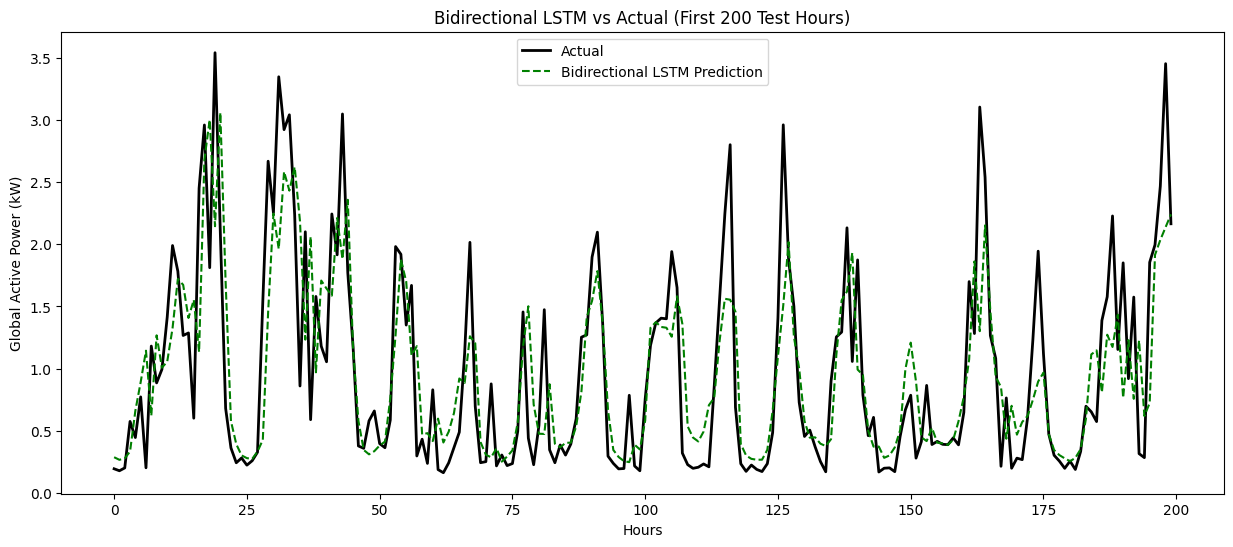

In [8]:
from tensorflow.keras.layers import Bidirectional

print("\n=== EXPERIMENT 4: Bidirectional LSTM (with 1h Lag) ===")

# 1. Prepare Data (Using the successful 1h Lag configuration)
# We keep the same lags that worked well in Exp 3
EXP4_LAGS = [1, 24, 168]
df_exp4 = create_time_series_features(df_hourly, EXP4_LAGS)

# Use the CORRECTED data preparation function (no leakage)
X_train, y_train, X_test, y_test, scaler_y, y_true = prepare_lstm_data_corrected(df_exp4)

# 2. Define Bidirectional Model
model_bi = Sequential()

# Layer 1: Bidirectional LSTM
# Note: We wrap the LSTM layer inside 'Bidirectional()'
# Default merge_mode is 'concat', so 100 units becomes 200 output features
model_bi.add(Bidirectional(LSTM(units=100, activation='relu', return_sequences=True),
                           input_shape=(1, X_train.shape[2])))
model_bi.add(Dropout(0.2))

# Layer 2: Bidirectional LSTM
model_bi.add(Bidirectional(LSTM(units=50, activation='relu', return_sequences=False)))
model_bi.add(Dropout(0.2))

# Output Layer
model_bi.add(Dense(units=1))

model_bi.compile(optimizer='adam', loss='mse')

# 3. Train
# We use the same training parameters as your successful run to compare fairly
history_bi = model_bi.fit(
    X_train, y_train,
    epochs=150,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)],
    verbose=1
)

# 4. Predict and Evaluate
pred_scaled_bi = model_bi.predict(X_test)
pred_bi = scaler_y.inverse_transform(pred_scaled_bi)

rmse_bi = sqrt(mean_squared_error(y_true, pred_bi))
mae_bi = mean_absolute_error(y_true, pred_bi)

print(f"\nExperiment 4 (Bidirectional) Results:")
print(f"RMSE: {rmse_bi:.4f}")
print(f"MAE:  {mae_bi:.4f}")

# Optional: Visual Comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
# Plot only the first 200 hours of the test set for clarity
plt.plot(y_true.values[:200], label='Actual', color='black', linewidth=2)
plt.plot(pred_bi[:200], label='Bidirectional LSTM Prediction', color='green', linestyle='--')
plt.title('Bidirectional LSTM vs Actual (First 200 Test Hours)')
plt.xlabel('Hours')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()